<a href="https://colab.research.google.com/github/omriak/omri_project_files/blob/main/main_trainingV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


Imports section & globals parameters

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Resizing
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import cv2 as cv
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)

# main path:
path_folder = os.path.join('/content/drive/MyDrive/Project_OmriAkrish/project_code_files/training_data')



Function section

In [13]:
from tensorflow._api.v2 import data
def upsample_100(data):
    current_N = np.shape(data)
    new_data = np.zeros(shape=(100,current_N[1],current_N[2]))
    for i in range(0,100):
        new_data[i,:,:] = data[int(np.floor((current_N[0]*i)/100)),:,:]
    return new_data

def DFS():
    DFS_indexlist = np.array([2, 21, 9, 10,  11,  12, 25,  12,  24,  12,  11, 10, 9,
                             21, 3, 4, 3, 21, 5, 6, 7, 8, 23, 8, 22, 8, 7, 6, 5, 21,
                             2, 1, 13, 14, 15, 16, 15, 14, 13, 1, 17, 18, 19, 20, 19,
                             18, 17, 1, 2])
    DFS_indexlist = DFS_indexlist-1
    return DFS_indexlist

# Nicely formatted time string

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def build_image_resizer(Oheight,Owidth,Iheight,Iwidth,R):
    model = Sequential()
    model.add(Resizing(Oheight, Owidth, interpolation="bilinear" , input_shape=(Iheight,Iwidth,R)))
    return model

def build_generator(seed_size):
    # seed_size is z+c where c is the class sagment
    model = Sequential()
    
    #input layer
    model.add(Dense(4*4*512,activation="relu",input_dim=seed_size)) 
    model.add(Reshape((4,4,512)))

    # Mid CNN layer
    model.add(UpSampling2D(size=(2, 2),interpolation = 'bilinear'))
    model.add(Conv2D(256,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D(size=(2, 2),interpolation = 'bilinear'))
    model.add(Conv2D(128,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D(size=(2, 2),interpolation = 'bilinear'))
    model.add(Conv2D(64,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(Activation("relu"))
    
    # Final CNN layer
    model.add(UpSampling2D(size=(2, 2),interpolation = 'bilinear'))
    model.add(Conv2D(2,kernel_size=(3,3),strides = (1, 1),padding="same",use_bias = False))
    model.add(Activation("tanh"))
    return model


def build_discriminator(image_shape):
    model = Sequential()
    
    #input layer first using resizer
    model.add(Conv2D(64, kernel_size=(4,4), strides=(2,2), input_shape=image_shape, padding="same",use_bias = False))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, kernel_size=(4,4), strides=(2,2),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, kernel_size=(4,4), strides=(2,2),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(2,2),padding="same",use_bias = False))
    model.add(BatchNormalization(epsilon=10**-5,momentum=0.1))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

#traning module


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def add_class(images):
    images = images.numpy()
    s = images.shape
    zero = np.zeros((s[0], s[1], s[2], 5))  
    one = np.ones((s[0], s[1], s[2], 1)) 
    class1 = np.append(zero, one, axis=3)
    return  np.append(images, class1, axis=3)
    
def get_imgbatch_class(dataset, i):
      data = list(dataset.as_numpy_iterator())
      return data[i][:,:,:,3:9]


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,seed,imgbatch_class):
    #generator_resizer = build_image_resizer(128,128)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
        generated_images = generator(seed, training=True)
        #add class to generated_images before deliver to discriminator
        generated_images = tf.concat([generated_images,tf.ones((BATCH_SIZE,64,64,1)),imgbatch_class], 3)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
    
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables),
    experimental_aggregate_gradients=False)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables),
    experimental_aggregate_gradients=False)
    return gen_loss,disc_loss

def one_seed():
    seed = np.random.normal(0, 1,100)
    c = np.asarray((0,0,0,0,0,1))
    fixed_seed = np.append(seed,c)
    return fixed_seed

def batch_seed(dataset, i):
      data = list(dataset.as_numpy_iterator())
      seed = np.random.normal(0, 1,(data[i].shape[0],100))
      return np.append(seed ,data[i][:,0,0,3:9], axis=1)

def train(dataset, epochs):
    start = time.time()
    gen_loss_total_list = []
    disc_loss_total_list = []

    for epoch in range(epochs):
        epoch_start = time.time()
        gen_loss_list = []
        disc_loss_list = []
        i=0
        for image_batch in tqdm(dataset):
            seed = batch_seed(dataset,i)
            t = train_step(image_batch,seed,get_imgbatch_class(dataset, i))
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            i = i+1

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'f' {hms_string(epoch_elapsed)}')

        gen_loss_total_list.append(g_loss)
        disc_loss_total_list.append(d_loss)
        
    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')
    return gen_loss_total_list , disc_loss_total_list

def get_class_all(n,numofclass,betchsize):
  if n == numofclass:
    one = tf.zeros((betchsize,64,64,numofclass-1))
    two = tf.ones((betchsize,64,64,1))
    return tf.concat([one,two],3)
  elif n == 1:
    one = tf.ones((betchsize,64,64,1))
    two = tf.zeros((betchsize,64,64,numofclass-1))
    return tf.concat([one,two],3)
  else:
    one = tf.zeros((betchsize,64,64,n-1))
    two = tf.ones((betchsize,64,64,1))
    three = tf.zeros((betchsize,64,64,numofclass-n))
  return tf.concat([one,two,three],3)

Main

In [4]:
# #load data:
print("Load training image binary...")
training_data =[];
dirs = os.listdir(path_folder)
for action_file in tqdm(dirs[0:6]):
    training_binary_path = os.path.join(path_folder,action_file)
    training_data.append(np.load(training_binary_path,allow_pickle=True))

#cast to np array
raining_data = np.asanyarray(training_data, dtype = object)

#normlize
print("Normlizing all....")
training_data_normalize =[];
for i in tqdm(range(len(training_data))):
  training_data[i][:] = tf.convert_to_tensor(training_data[i][:])
  training_data_normalize.append(tf.map_fn(lambda x: tf.image.per_image_standardization(x), training_data[i][:], parallel_iterations=training_data[i][:].shape[0], dtype=tf.float32))

#build resizer
print("building resizer (64,64,100,49,3) ....")
resizer = build_image_resizer(64,64,100,49,3)

training_data_with_class =[]
print("adding class...")
#arrange data for traing
for i,training_data_by_class in tqdm(enumerate(training_data_normalize)):
  training_data_r = resizer(training_data_by_class, training=False)
  class1 = get_class_all(1+(i%6),6,training_data_r.shape[0])
  training_data_r_temp = np.append(training_data_r, class1, axis=3)
  training_data_r_temp[:, :, :, 2] = np.ones_like(training_data_r_temp[:, :, :, 2])
  training_data_with_class.append(training_data_r_temp)

cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

training_data_serial = np.concatenate(training_data_with_class,axis=0)
print(training_data_serial.shape)

generator = build_generator(106)
discriminator = build_discriminator((64,64,9))
resizer = build_image_resizer(64,64,100,49,3)
Model.summary(resizer)
Model.summary(generator)
Model.summary(discriminator)
#-------------------------------
#tested throw here
#-------------------------------


Load training image binary...


100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Normlizing all....


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:48<00:00,  8.06s/it]


building resizer (64,64,100,49,3) ....
adding class...


6it [00:01,  3.31it/s]


(5637, 64, 64, 9)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 64, 3)         0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              876544    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 512)        0         
 )                                                               
                    

Test code here:

In [14]:
EPOCHS = 1
BATCH_SIZE = 32
BUFFER_SIZE = 60000
SEED_SIZE = 106
# Batch and shuffle the data
training_data_serial = np.concatenate(training_data_with_class,axis=0)
train_dataset = tf.data.Dataset.from_tensor_slices(training_data_serial).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# lr = [1.5e-4 , 2e-4 , 5e-4 ,1e-3]
# loss = []
# for i in lr:
#   #set optimizer:
#   enerator_optimizer = tf.keras.optimizers.Adam(i,0.5)
#   discriminator_optimizer = tf.keras.optimizers.Adam(i,0.5)
gen_loss , disc_loss = train(train_dataset, EPOCHS)
  # loss.append([gen_loss , disc_loss]) 
  

  0%|          | 0/177 [00:00<?, ?it/s]

(32, 64, 64, 6)
(32, 64, 64, 9)
tf.Tensor(
[[ 0.4859798   0.41858444  0.4056258  ... -0.01408621 -0.02643148
   0.08681796]
 [ 0.4752549   0.4650914   0.41763723 ... -0.64242476 -0.6173055
  -0.02727297]
 [ 0.58891076  0.65022343  0.6152216  ... -0.55606574 -0.5264227
  -0.01631273]
 ...
 [ 0.6898779   0.64831483  0.70004976 ...  0.5275566   0.20290524
  -0.23149991]
 [ 0.5450103   0.5286756   0.587479   ...  0.4501595   0.23993409
  -0.22301202]
 [ 0.15506081  0.03690568 -0.00345863 ... -0.26322103 -0.24927594
  -0.49420145]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[-0.80202055 -0.6028136  -0.6660345  ... -0.04774915  0.10794563
   0.077199  ]
 [-0.24802895 -0.0149004  -0.02780016 ... -0.00235492  0.02111422
  -0.2533665 ]
 [-0.0886853   0.08791995  0.09348153 ... -0.00290491 -0.04406307
  -0.2562017 ]
 ...
 [-0.7391515  -0.2837095  -0.18761043 ... -0.28384912 -0.04384262
   0.2197593 ]
 [-0.7047115  -0.247665   -0.05423805 ... -0.09275822  0.12231659
   0.28176945]
 [-0.21496889 

  0%|          | 0/177 [00:06<?, ?it/s]


KeyboardInterrupt: ignored

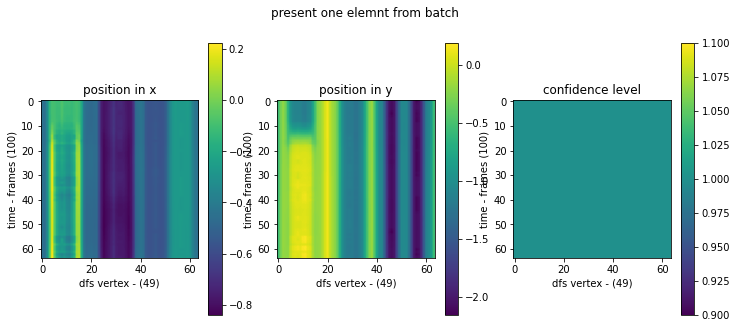

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(3):
  axs = plt.subplot(130+i+1)
  plt.imshow(training_data_with_class[2][0, :, :, i])
  plt.colorbar()
  plt.ylabel('time - frames (100)')
  plt.xlabel('dfs vertex - (49)')
  if i==0:
    axs.set_title('position in x')
  if i==1:
    axs.set_title('position in y')
  if i==2:
    axs.set_title('confidence level')
plt.suptitle('present one elemnt from batch')
plt.show()

In [23]:
def save_modle(folder, name, model,override):
    # serialize model to JSON
    if os.path.isdir(os.path.join(path_folder,folder)):
      if override:
        print("override files")
        json_path = os.path.join(path_folder,folder,name+".json")
        w_path = os.path.join(path_folder,folder,name+".h5")
        model_json = model.to_json()
        with open(json_path, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights(w_path)
        print("Saved model to drive....")
      else:
        print("path exsist overide disable")
        print("dont saving")
    else:
      os.makedirs(os.path.join(path_folder,folder))
      json_path = os.path.join(path_folder,folder,name+".json")
      w_path = os.path.join(path_folder,folder,name+".h5")
      model_json = model.to_json()
      with open(json_path, "w") as json_file:
          json_file.write(model_json)
      # serialize weights to HDF5
      model.save_weights(w_path)
      print("Saved model to drive....")
    
    # later...
def load_modle(name, folder):    
    # load json and create model
    json_path = os.path.join(path_folder,folder,name+".json")
    w_path = os.path.join(path_folder,folder,name+".h5")
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(w_path)
    print("Loaded model from drive")
    return loaded_model

In [24]:
save_modle("save01", "gen", generator,False)

Saved model to drive....
